<img src="./img/Logo.png" align="right" width="50%"></img>
# MissionAtlantic GeoNode Workshop
# How to use OGC webservices offered by the MissionAtlantic GeoNode in your data analysis

## 3. Subset & download data using OGC Web Feature and Coverage Services (WFS/WCS)

The OWSLib library is a python library that makes accessing data and metadata through OGC services possible. The library abstracts all of the traditional HTTP API calls into programmatic function calls. We will be using this library throughout the tutorial to interact with the MissionAtlantic GeoNode OGC services.

The library is available from GitHub @  https://github.com/geopython/OWSLib

In [1]:
from owslib.wfs import WebFeatureService
from owslib.wcs import WebCoverageService
from matplotlib import pyplot as plt
import contextily as cx

### 3.1 Get vector data with WFS

#### Create a WebFeatureService (WFS) object
Note that we use version 1.1.0 as in OWSLib this version has support for [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [2]:
wfs = WebFeatureService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.1.0')

#### Find out what the WFS has to offer. Service metadata:

In [3]:
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
Mission Atlantic GeoNode WFS service
This is the WFS service of the Mission Atlantic GeoNode


#### See available methods

In [4]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

#### Get available formats

In [5]:
wfs.getOperationByName('GetFeature').parameters

{'resultType': {'values': ['results', 'hits']},
 'outputFormat': {'values': ['text/xml; subtype=gml/3.1.1',
   'GML2',
   'KML',
   'SHAPE-ZIP',
   'application/gml+xml; version=3.2',
   'application/json',
   'application/vnd.google-earth.kml xml',
   'application/vnd.google-earth.kml+xml',
   'application/x-gpkg',
   'csv',
   'excel',
   'excel2007',
   'geopackage',
   'geopkg',
   'gml3',
   'gml32',
   'gpkg',
   'json',
   'text/csv',
   'text/javascript',
   'text/xml; subtype=gml/2.1.2',
   'text/xml; subtype=gml/3.2']}}

#### Find out what vector datasets (FeatureTypes) are available
Note that only vector datasets that are uploaded to the GeoNode and are publicly available are shown

In [6]:
list(wfs.contents)

['geonode:habitat_eez', 'geonode:Arosioetal2023_FCNN_mod_map']

In [7]:
# Select the desired dataset among the list returned above
dataset = 'geonode:habitat_eez'

#### Get the FeatureType Metadata an Bounding Box:

In [8]:
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)
bbox1 = wfs.contents[dataset].boundingBoxWGS84
print (bbox1)

Benthic habitats using EUNIS classification for the Brazilian EEZ
The dataset contains the shapefile of marine benthic broad habitats classified according to EUNIS classification for the Brazilian Exclusive Economic Zone region. It was developed using open access databases and GIS operations to develop two intermediate layers: (i) biological zones and (ii) substrate type. Both layers were combined to form the first continuous map of marine habitats for the entire region.
(-53.373234543183834, -37.24515427664852, -25.29094733519388, 8.742758415082022)


#### Get the FeatureType’s schema via `DescribeFeatureType`.
The dictionary returned is compatible with a [Fiona schema object](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.collection.Collection.schema).

In [9]:
wfs.get_schema(dataset)

{'properties': {'fid': 'int',
  'subs_class': 'string',
  'subs_nm': 'string',
  'biozone': 'long',
  'biozone_nm': 'string',
  'hab_class': 'long',
  'hab_nm': 'string',
  'OBJECTID': 'long',
  'PROV_CODE_': 'double',
  'PROVINCE': 'string',
  'REALM': 'string',
  'area': 'double',
  'perimeter': 'double'},
 'required': ['fid'],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'the_geom'}

#### Subset data with a bounding box

In [10]:
# Define the region of interest
roi = (-51.8,-2.5,-45.5,2.6) # Amazon River Estuary
# Subset data with a bounding box
response = wfs.getfeature(typename=dataset,
                          bbox=roi, #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}.json')
gdf

,id,fid,subs_class,subs_nm,biozone,biozone_nm,hab_class,hab_nm,OBJECTID,PROV_CODE_,PROVINCE,REALM,area,perimeter,geometry
0,habitat_eez.1,1,7,seabed,900,Abyssal,907,Abyssal seabed,4,1,North Brazil Shelf,Tropical Atlantic,15.298941,80.416758,"MULTIPOLYGON (((-40.65778 -0.15302, -40.73239 ..."
1,habitat_eez.4,4,1,mud,900,Abyssal,901,Abyssal mud,4,1,North Brazil Shelf,Tropical Atlantic,24.785386,67.749952,"MULTIPOLYGON (((-41.27169 -1.73772, -41.26587 ..."
2,habitat_eez.10,10,6,biogenic,200,Circalittoral,206,Circalittoral biogenic,4,1,North Brazil Shelf,Tropical Atlantic,0.037610,1.085747,"MULTIPOLYGON (((-47.11643 -0.32816, -47.10437 ..."
3,habitat_eez.12,12,6,biogenic,100,Infralittoral,106,Infralittoral biogenic,4,1,North Brazil Shelf,Tropical Atlantic,0.889348,17.677262,"MULTIPOLYGON (((-43.38831 -1.3031, -43.37452 -..."
4,habitat_eez.14,14,6,biogenic,300,Offshore circalittoral,306,Offshore circalittoral biogenic,4,1,North Brazil Shelf,Tropical Atlantic,0.943909,25.456827,"MULTIPOLYGON (((-45.4888 0.3229, -45.4888 0.31..."
5,habitat_eez.16,16,6,biogenic,400,Upper bathyal,406,Upper bathyal biogenic,4,1,North Brazil Shelf,Tropical Atlantic,0.017751,2.272946,"MULTIPOLYGON (((-43.52359 -1.07566, -43.52359 ..."
6,habitat_eez.18,18,2,sand,300,Offshore circalittoral,302,Offshore circalittoral sand,4,1,North Brazil Shelf,Tropical Atlantic,1.119783,40.369624,"MULTIPOLYGON (((-49.3651 0.11004, -49.36429 0...."
7,habitat_eez.21,21,1,mud,200,Circalittoral,201,Circalittoral mud,4,1,North Brazil Shelf,Tropical Atlantic,7.273779,51.506183,"MULTIPOLYGON (((-51.45677 4.51856, -51.46564 4..."
8,habitat_eez.24,24,4,coarse sediment,200,Circalittoral,204,Circalittoral coarse sediment,4,1,North Brazil Shelf,Tropical Atlantic,0.372765,10.455236,"MULTIPOLYGON (((-44.60021 -1.74514, -44.60014 ..."
9,habitat_eez.27,27,2,sand,200,Circalittoral,202,Circalittoral sand,4,1,North Brazil Shelf,Tropical Atlantic,1.328581,47.003795,"MULTIPOLYGON (((-49.63642 0.38318, -49.63619 0..."


Text(0.5, 1.0, 'Benthic substrate near the Amazon River Estuary')

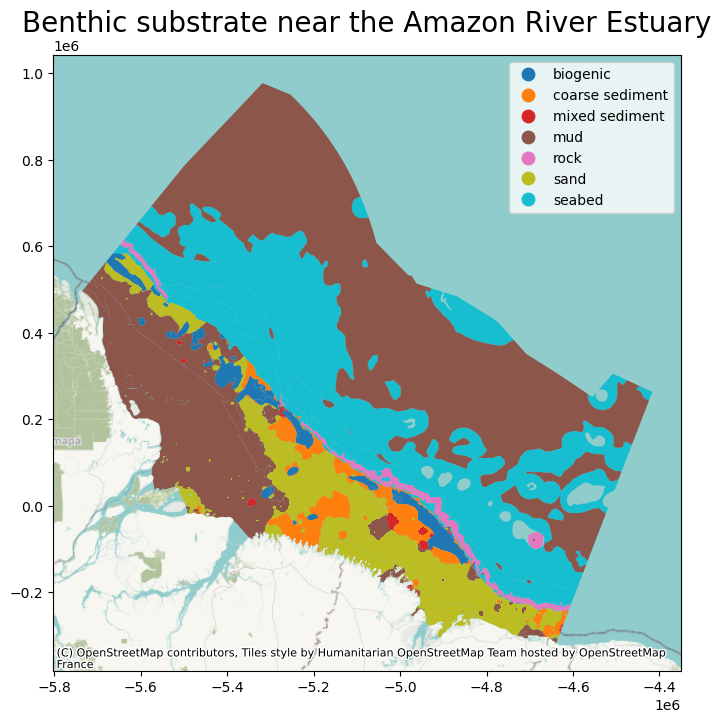

In [11]:
fig, ax = plt.subplots(1, figsize=(9,8))
# reproject to web mercator (EPSG:3857) and plot the map
gdf.to_crs(epsg=3857).plot(column='subs_nm',
                          categorical=True,
                          cmap='tab10',
                          legend= True,
                          alpha = 1,
                          ax=ax) # Add study areas colored by study region number
# add the background layer
cx.add_basemap(ax)
ax.set_title('Benthic substrate near the Amazon River Estuary',fontsize=20)

#### Subset data by attributes using [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [12]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
subs_filter = fes.PropertyIsEqualTo(propertyname='subs_nm', literal='mud') # areas with mud substrate
biozone_filter = fes.PropertyIsEqualTo(propertyname='biozone_nm', literal = 'Abyssal') # filter for abbysal biozones
filter = fes.And([subs_filter,biozone_filter]) # combine both filtering parameters using "AND"

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs.getfeature(typename=dataset,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}_filtered.json')
gdf

,id,fid,subs_class,subs_nm,biozone,biozone_nm,hab_class,hab_nm,OBJECTID,PROV_CODE_,PROVINCE,REALM,area,perimeter,geometry
0,habitat_eez.4,4,1,mud,900,Abyssal,901,Abyssal mud,4,1,North Brazil Shelf,Tropical Atlantic,24.785386,67.749952,"MULTIPOLYGON (((-41.27169 -1.73772, -41.26587 ..."
1,habitat_eez.5,5,1,mud,900,Abyssal,901,Abyssal mud,2,2,Tropical Southwestern Atlantic,Tropical Atlantic,97.369627,326.818574,"MULTIPOLYGON (((-40.55404 -24.10583, -40.44603..."
2,habitat_eez.6,6,1,mud,900,Abyssal,901,Abyssal mud,3,3,Warm Temperate Southwestern Atlantic,Temperate South America,48.005105,200.058446,"MULTIPOLYGON (((-45.05017 -34.40323, -45.05623..."


Text(0.5, 1.0, 'Benthic habitats of Abyssal Mud')

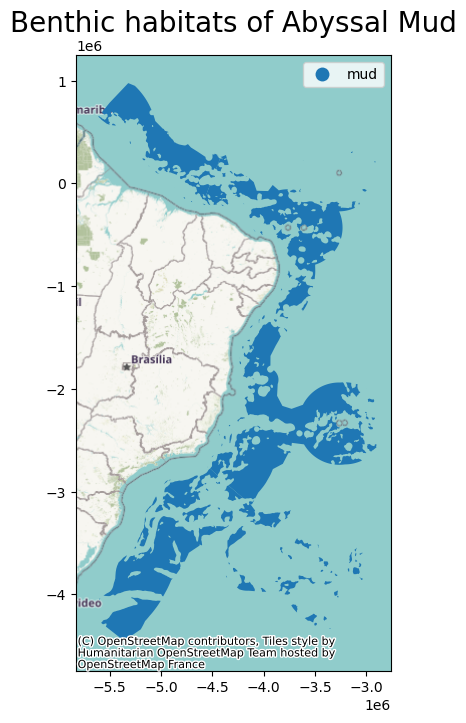

In [13]:
fig, ax = plt.subplots(1, figsize=(9,8))
# reproject to web mercator (EPSG:3857) and plot the map
gdf.to_crs(epsg=3857).plot(column='subs_nm',
                          categorical=True,
                          cmap='tab10',
                          legend= True,
                          alpha = 1,
                          ax=ax) # Add study areas colored by study region number
# add the background layer
cx.add_basemap(ax)
ax.set_title('Benthic habitats of Abyssal Mud',fontsize=20)

## Example 2: Combining Subset of WFS request with a WCS (Web Coverage Services) request
### 1. Define a new study area

In this example, we will be looking to subset the "Non-Hierarchical habitat classification in the Atlantic Ocean in 2016" dataset obtained from the Mission Atlantic Geonode, to the marine region of the Greater North Sea (as defined by ICES Ecoregions).

#### 1.1 Connect to the MarineRegions.org WebFeatureService 
Marine Regions is an integration of the VLIMAR Gazetteer and the VLIZ Maritime Boundaries Geodatabase. The VLIMAR Gazetteer is a database with geographic, mainly marine names such as seas, sandbanks, seamounts, ridges, bays or even standard sampling stations used in marine research. It is accessible at: https://www.marineregions.org/gazetteer.php?p=search

In [14]:
wfs2 = WebFeatureService('https://geo.vliz.be/geoserver/MarineRegions/wfs', version= '1.1.0')

#Inspect available datasets
print(wfs2.identification.type)
print(wfs2.identification.version)
print(wfs2.identification.title)
print(wfs2.identification.abstract)
list(wfs2.contents)

WFS
1.1.0
Flanders Marine Institute (VLIZ) - WFS Service
This is the reference implementation of OGC WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


['MarineRegions:eez_archipelagic_waters',
 'MarineRegions:arcticmarineareas',
 'MarineRegions:brasdorlakebiospherereserve',
 'MarineRegions:isa_ccz_managementarea',
 'MarineRegions:coasts_subnational',
 'MarineRegions:coasts_per_ocean',
 'MarineRegions:eez_24nm',
 'MarineRegions:comarge',
 'MarineRegions:cross_dateline_polygons',
 'MarineRegions:eca_reg13_nox',
 'MarineRegions:eca_reg14_sox_pm',
 'MarineRegions:eez',
 'MarineRegions:ecs',
 'MarineRegions:ecs_boundaries',
 'MarineRegions:fadaregions',
 'MarineRegions:fao',
 'MarineRegions:tnc_wwf_feow_hydrosheds',
 'MarineRegions:gsas_mediterraneanfishingzones',
 'MarineRegions:longhurst',
 'MarineRegions:goas',
 'MarineRegions:haedatgrids_polygon',
 'MarineRegions:high_seas',
 'MarineRegions:ices_ecoregions',
 'MarineRegions:ices_areas',
 'MarineRegions:ices_statistical_rectangles',
 'MarineRegions:iho',
 'MarineRegions:iho_quadrants_20150810',
 'MarineRegions:eez_internal_waters',
 'MarineRegions:itmarbiogeogsector_bianchi',
 'MarineR

In [15]:
#Define desired regional classification, here ICES Ecoregions
dataset2 = 'MarineRegions:ices_ecoregions'

# See available methods
[operation.name for operation in wfs2.operations]



['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

In [16]:
#Inspect ICES Ecoregions dataset
print(wfs2.contents[dataset2].title)
print(wfs2.contents[dataset2].abstract)
bbox = wfs2.contents[dataset2].boundingBoxWGS84
print (bbox)

ICES Ecoregions (2015)
Delineation of the ICES Ecoregions was originally described in ICES Advice ACFM/ACE report(2004).

In the present updated version, the delineation has been updated to account for additional policy objectives and reconciling of legislation (eg the MSFD and the EU water and habitats directives)

The differences are based on the four principles:
1. Within the EU accept the MSFD regional and sub-regional definitions.
2. Separate Icelandic Seas from those around Greenland.
3. Use Large Marine Ecosystem units to define the Arctic Ocean.
4. Use the accepted Norwegian regional management plans definitions of the Norwegian and Barents Seas.

The Ecoregions were proposed to assist the implementation of the ecosystem approach in European waters
(-44.0000000000998, 30.2670495513959, 68.5000001347984, 90.0000000001001)


In [17]:
# Get the FeatureType’s schema via `DescribeFeatureType`
wfs2.get_schema(dataset2)

{'properties': {'objectid': 'int',
  'ecoregion': 'string',
  'mrgid': 'int',
  'longitude': 'decimal',
  'latitude': 'decimal',
  'area_km2': 'decimal',
  'placetype': 'string',
  'placetypei': 'int',
  'parent': 'string',
  'parentid': 'int',
  'source': 'string',
  'sourceid': 'int',
  'lon_min': 'decimal',
  'lon_max': 'decimal',
  'lat_min': 'decimal',
  'lat_max': 'decimal'},
 'required': [],
 'geometry': 'MultiPolygon',
 'geometry_column': 'the_geom'}

#### 1.2 Inspect the ICES Ecoregions datasets
Listing all available regional delimitations based on the ICES Ecoregions classification

In [18]:
response = wfs2.getfeature(typename=dataset2,
                          bbox=(bbox), 
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset2.replace(":","_")}.json')
gdf

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.1,1,Greenland Sea,36310,-28.070627,69.670326,1.065385e+06,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-44.000000,5.677908,56.560460,82.304253,"MULTIPOLYGON (((-43.99177 60.29694, -44 60.294..."
1,ices_ecoregions.2,2,Bay of Biscay and the Iberian Coast,36311,-8.886815,42.662908,7.557796e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-13.861560,-0.146245,36.000000,48.000002,"MULTIPOLYGON (((-5.6 36.01104, -5.6 36, -5.609..."
2,ices_ecoregions.3,3,Azores,36312,-28.438624,39.154203,7.928794e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-35.579300,-20.855320,36.000000,43.067630,"MULTIPOLYGON (((-21.05878 36, -23.49448 36, -2..."
3,ices_ecoregions.4,4,Western Mediterranean Sea,22167,6.109270,39.531134,8.444074e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.600000,16.223122,35.070668,44.427203,"MULTIPOLYGON (((2.99963 43.1422, 2.99973 43.14..."
4,ices_ecoregions.5,5,Ionian Sea and the Central Mediterranean Sea,36313,17.320194,35.190387,7.726428e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,10.015849,24.122811,30.267050,40.520659,"MULTIPOLYGON (((24.12281 34.8018, 24.12272 34...."
5,ices_ecoregions.6,6,Black Sea,22172,34.262870,43.464598,4.747685e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,26.175552,42.354960,39.998909,47.376395,"MULTIPOLYGON (((41.58356 42.40528, 41.57035 42..."
6,ices_ecoregions.7,7,Adriatic Sea,36314,16.118553,42.714787,1.392988e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,12.065226,20.020828,39.744192,45.808914,"MULTIPOLYGON (((19.99367 39.79384, 19.99293 39..."
7,ices_ecoregions.8,8,Aegean-Levantine Sea,22169,28.686066,34.822184,7.567145e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,22.149885,36.215729,30.756594,41.091326,"MULTIPOLYGON (((25.74529 36.79303, 25.7435 36...."
8,ices_ecoregions.9,9,Celtic Seas,22173,-9.264609,54.591504,9.177512e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-16.090850,1.806284,48.000002,63.890844,"MULTIPOLYGON (((1.37123 62, 1.37123 62, 1.5063..."
9,ices_ecoregions.10,10,Baltic Sea,22170,19.497017,58.713587,3.999565e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,9.419914,31.685704,52.871122,67.080588,"MULTIPOLYGON (((11.0789 53.14186, 11.09182 53...."


#### 1.3 Write a filter to select the desired region (Greater North Sea)

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.11,11,Greater North Sea,36317,2.932991,56.0119,670833.140245,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.0,13.062911,48.000002,62.000003,"MULTIPOLYGON (((-4.56139 48, -4.56354 48, -4.5..."


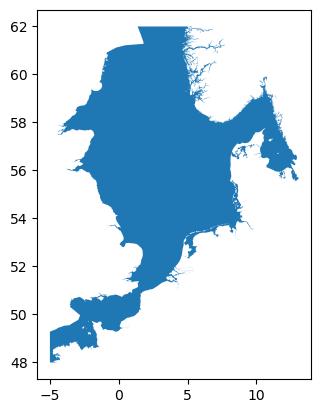

In [19]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
filter = fes.PropertyIsEqualTo(propertyname='ecoregion', literal='Greater North Sea') # Specifying the needed Ecoregion

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs2.getfeature(typename = dataset2,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
Study_area = gpd.read_file(f'data/{dataset2.replace(":","_")}_filtered.json')

# Plot and inspect the study area dataset
Study_area.plot()
Study_area



### 3.2 Get raster data with WCS

#### <i>Create a WebCoverageService (WCS) object</i>

In [20]:
wcs = WebCoverageService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.0.0')

#### <i>Get a list of available coverages</i>

In [21]:
for coverage_name in wcs.contents.keys():
    print(coverage_name)

geonode:AAHA_Level1_allClasses
geonode:AAHA_Level2_allClasses
geonode:AAHA_Level3_allClasses
geonode:AcaArc_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic
geonode:DisLop_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:FinalAbundance_Deania_calcea
geonode:FinalAbundance_Deania_profundorum
geonode:FinalAbundance_Etmopterus_pusillus
geonode:FinalAbundance_Etmopterus_spinax
geonode:FinalAbundance_Galeorhinus_galeus
geonode:FinalAbundance_Raja_clavata
geonode:Kstelliferun_density_clipped_GHO_reprojectedGeoNode
geonode:LophReef_threhsolded_GHO_reprojectedGeoNode
geonode:N1_p
geonode:N3_n
geonode:N5_s
geonode:Night_Pleuromamma_1960_2019
geonode:O2_o
geonode:O3_TA
geonode:O3_c
geonode:PherCarp_threhsolded_GHO_reprojectedGeoNode
geonode:catches_sum_SP1_Clupea_harengus
geonode:catches_sum_SP71_Conger_conger
geonode:catches_sum_SP66_Coryphaena_hippurus
geonode:catches_sum_SP11_Engraulis_encrasic

#### <i>Define the dataset</i>

In [22]:
dataset = 'geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic'

#### <i>Retrieve a list of available properties of a coverage</i>

In [23]:
for item in dir(wcs.contents[dataset]):
    if "_" not in item:
        print(item)

abstract
axisDescriptions
boundingBox
boundingBoxWGS84
boundingboxes
crsOptions
defaulttimeposition
grid
id
keywords
styles
supportedCRS
supportedFormats
timelimits
timepositions
title


#### <i>Retrieve grid property information</i>

In [24]:
for item in dir(wcs.contents[dataset].grid):
    if "_" not in item:
        print(item + ": " + str(wcs.contents[dataset].grid.__dict__[item]))

axislabels: ['x', 'y']
dimension: 2
highlimits: ['1147', '1746']
lowlimits: ['0', '0']
offsetvectors: [['0.0833333333333333', '0.0'], ['0.0', '-0.0833333333333333']]
origin: ['-65.95833333333336', '83.29166666666667']


#### Get geo-bounding boxes and native CRS

In [25]:
wcs.contents[dataset].boundingBoxWGS84

(-66.00000000000003, -62.24999999999994, 29.6666666666666, 83.33333333333334)

#### Retrieve supported formats

In [26]:
wcs.contents[dataset].supportedFormats

['ArcGrid',
 'GeoTIFF',
 'GIF',
 'GeoPackage (mosaic)',
 'ImageMosaic',
 'JPEG',
 'MBTiles',
 'NetCDF',
 'PNG',
 'TIFF',
 'org.geoserver.catalog.testreader.CustomFormat']

#### Subset and download raster data using a GetCoverage request

In [27]:
# get parameters for grid
bbox2 = Study_area.bounds.values[0].tolist() # get bbox for the Greater North Sea study area 
crs2 = Study_area.crs.srs # get crs of the Study Area file
print(bbox2)
print(crs2)

[-5.00000003, 48.00000191, 13.06291068, 62.00000256]
EPSG:4326


Optional Step: Manually adjust the Bounding Box of raster dataset, to cover an area sligthly larger than that of the study area.

In [28]:
#Adding 2 decimal degrees to each side of the bbox

bbox2 = [bbox2[0]-2,bbox2[1]-2,bbox2[2]+2,bbox2[3]+2]
print(bbox2)

[-7.00000003, 46.00000191, 15.06291068, 64.00000256]


In [29]:
# GetCoverage request
response = wcs.getCoverage(identifier=dataset,
                           bbox=bbox2,
                           format='GeoTIFF',
                           crs=crs2,
                           resx=0.00833333,resy=0.00833333,
                           interpolation='bicubic')
print(response.geturl())
with open(f'data/{dataset.replace(":","_")}.tif','wb') as outfile:
    outfile.write(response.read())

https://geonode.missionatlantic.eu/geoserver/wcs?version=1.0.0&request=GetCoverage&service=WCS&Coverage=geonode%3AAtl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic&BBox=-7.00000003%2C46.00000191%2C15.06291068%2C64.00000256&crs=EPSG%3A4326&format=GeoTIFF&resx=0.00833333&resy=0.00833333&interpolation=bicubic


#### Open rasterdata in an xarray object using the rasterio library

In [30]:
import rioxarray
rasterdata = rioxarray.open_rasterio(f'data/{dataset.replace(":","_")}.tif')
rasterdata

<xarray.DataArray (band: 1, y: 2160, x: 2648)> Size: 23MB
[5719680 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 21kB -6.996 -6.988 -6.979 ... 15.04 15.05 15.06
  * y            (y) float64 17kB 64.0 63.99 63.98 63.97 ... 46.02 46.01 46.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

#### Plot a map of the rasterdata overlaid with the study area

Text(0.5, 1.0, 'Non-Hierarchical habitat classification \n In the Greater North Sea')

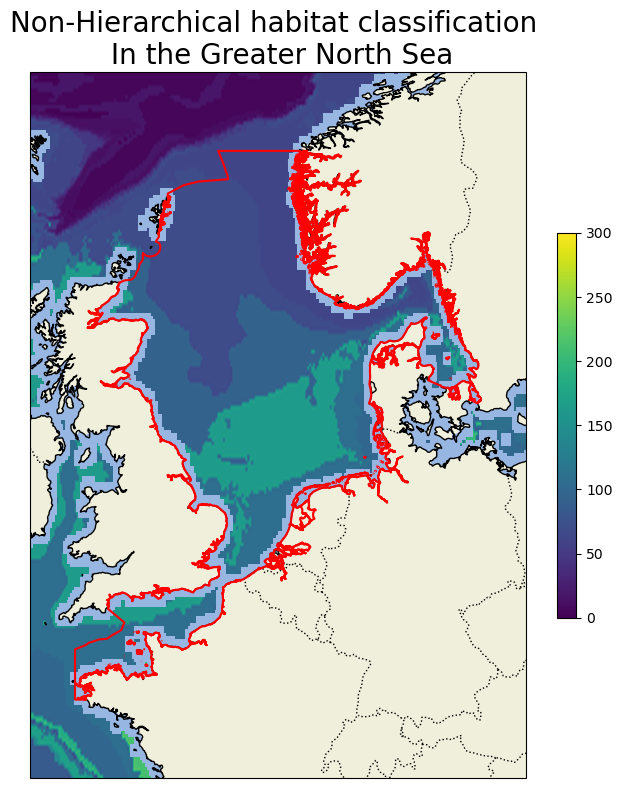

In [31]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


fig = plt.figure(figsize=(8,10))# Increase the figure size
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#add Basemap features from Cartopy
ax.add_feature(cartopy.feature.OCEAN, )
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines(resolution='10m')

#plot the data
cbar_kwargs = {'shrink':0.5, 'extend': 'neither'}                                                             
rasterdata.plot(ax = ax, cmap = 'viridis', vmin =0, vmax = 300, cbar_kwargs = cbar_kwargs) # plot raster data
Study_area.boundary.plot(ax=ax, color=None, edgecolor = 'red', label = 'Study Area')

ax.set_title('Non-Hierarchical habitat classification \n In the Greater North Sea', fontsize=20)


### [>> Next: Use OGC services from common GIS software](./4_OGC_services_from_common_GIS_software.ipynb)

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>